# Measuring fluorescence outside of SuperSegger

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matlab.engine as matlab
import skimage.io
import skimage.filters
import mscl.plotting
import mscl.image
import glob
colors = mscl.plotting.set_plotting_style()
eng = matlab.start_matlab()
%matplotlib inline

## The problem 

Throughtout all of my dilution analyses thus far, the resulting calibration factors have been off by a factor of six to ten higher than they should be. After performing this experiment using sfGFP for the MscL titration studies, using mCherry for the LacI titration studies, and using three different cameras, this problem persists. Since it is so consistent between these very different experiments, my only conclusion is that this must be coming from the fluorescence processing in the SuperSegger analysis. Without digging through the source code, it's pretty difficult to determine what it's doing under the hood beyond a simple background fluorescence subtraction. 

Another source for this discrepancy is in my calculation of the dilution factor, but as it agrees with the computed mean values through binning, I don't think that this is the case. 





### Testing the issue.

There are two different ways in which I can test my hypothesis. I can either 1) generate fake data to pass into super segger to see if I get the correct fluorescence values out, or 2) use the resulting segmentation masks to mask one one of the fluorescence images in Python, since I'm more familiar with what's going on under the hood. Below, I perform both of these approaches. The mystery dies today. 

## Reading the fluroescence images in Python

In order for this analysis to work, I have to have some reliable way to get the segmentation masks and properly identify each cell. Since I designed the experiment on 2018-01-19 to have only a fluorescence image taken at the final frame, this should be a relatively simple procedure. 

Below, I define the data directory and load one of the `cell.mat` files.

Text(0.5,1,'mCherry image')

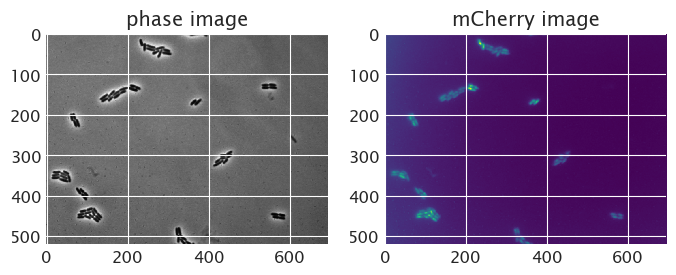

In [170]:
# Define the data directory.
data_dir = '../../../data/images/20180119_37C_glucose_O2_dilution/20180119_growth_1/xy9/'

# Load one of the mat files.
f = glob.glob('{0}cell/*ell*.mat'.format(data_dir))[-1]
eng.workspace['f'] = f
ex_mat = eng.eval('load(f)')
frame = ex_mat['death']

# Load the appropriate phase and fluorescence image.
phase_file = glob.glob('../../../data/images/20180119_37C_glucose_O2_dilution/20180119_growth_1/raw_im/*t*{0}xy009c1.tif'.format(int(frame-1)))
phase_im = skimage.io.imread(phase_file[0])
fluo_file = glob.glob('../../../data/images/20180119_37C_glucose_O2_dilution/20180119_growth_1/raw_im/*t*{0}xy009c2.tif'.format(int(frame-1)))
fluo_im = skimage.io.imread(fluo_file[0])

# Show both images.
fig, ax = plt.subplots(1, 2)
_ = ax[0].imshow(phase_im, cmap='Greys_r')
ax[0].set_title('phase image')
_ = ax[1].imshow(fluo_im, cmap='viridis')
ax[1].set_title('mCherry image')

From the `.mat` file, I have access to the segmentation mask for each frame. Here, I'll take the mask and bounding box from this frame and will show it alongsize the phase image. 

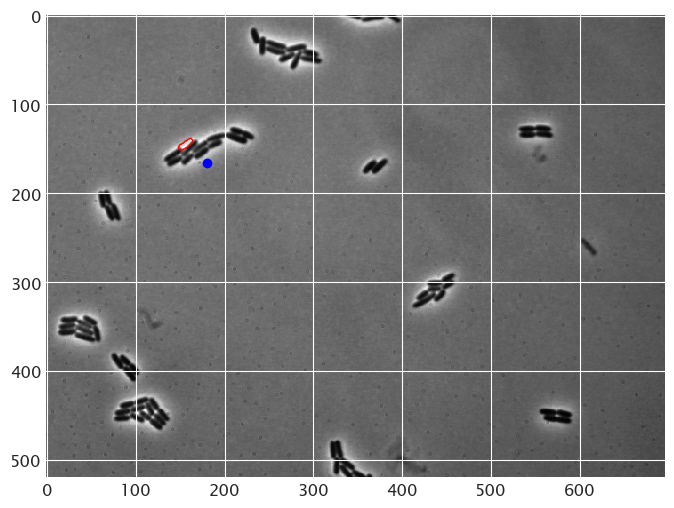

In [172]:
# Extract the segmentation mask in the bounding box from the mat file.
mask = np.array(ex_mat['CellA'][-1]['mask']).astype(int)
bbox = np.round(ex_mat['CellA'][-1]['BB'][0]).astype(int)
centroid = ex_mat['CellA'][-1]['r'][0]

# Make a blank image the size of the pahe image.
phase_blank = np.zeros_like(phase_im)

# Add the mask to the blank image at the bounding box position.
x = np.sort(bbox[[1, 3]])
y = np.sort(bbox[[0, 2]])
phase_blank[x[1] - x[0]:x[1] + 1, y[1] - y[0]:y[1] + 1] = mask

# Find the outline.
boundary = skimage.measure.find_contours(phase_blank, level=0)[0]
x = boundary[:, 0]
y = boundary[:, 1]

#  Plot the image and the outline.
fig, ax = plt.subplots(1, 1)
_ = ax.imshow(phase_im, cmap='Greys_r')
_ = ax.plot(y, x, 'r-', lw=1)
_ = ax.plot(centroid[0], centroid[1], 'bo')


In [161]:
centroid

matlab.double([[180.2,165.9294117647059]])

In [157]:
ex_mat['CellA'][-1]['']

matlab.double([[180.2,165.9294117647059]])

##  Generating fake data

In [1]:
import skimage.morphology

/Users/gchure/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: test_im_t0000xy1c2.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/Users/gchure/anaconda/lib/python3.6/site-packages/skimage/io/_io.py:132: UserWarning: test_im_t0000xy1c1.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


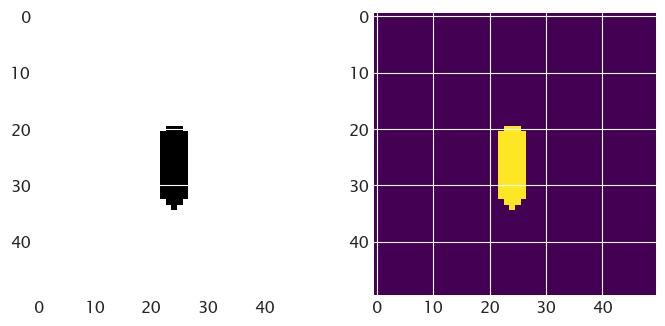

In [57]:
# Set up a fake  fluorescence image. 
ones_im = np.zeros((50, 50)).astype(np.uint16)
X, Y = np.ogrid[0:10, 0:10] 
ellipse = (1./3 * (X - 4)**2 + (Y - 4)**2 < 3**2).astype(np.uint16)
ones_im[20:30, 20:30] += ellipse
ones_im[25:35, 20:30] += ellipse
ones_im = np.array(ones_im > 0).astype(np.uint16)
ones_im *= 500
ones_im += 100

# Set up a fake phase image.
phase_im = np.ones((50, 50)).astype(np.uint16)
phase_im[20:30, 20:30] -= ellipse 
phase_im[25:35, 20:30] -= ellipse 
phase_im = np.array(phase_im == 1).astype(np.uint16) * 300
phase_im += 200

# Show the fake image and save.
fig, ax = plt.subplots(1, 2)
_ = ax[0].imshow(phase_im, cmap='Greys_r')
_ = ax[1].imshow(ones_im, cmap='viridis')
skimage.io.imsave('test_im_t0000xy1c2.tif', ones_im)
skimage.io.imsave('test_im_t0000xy1c1.tif', phase_im)

After making these images, I processed them using SuperSegger. 


In [89]:
# Load in the cell file.
f = './xy1/cell/cell0000001.mat'
eng.workspace['f'] = f
fake_mat = eng.eval('load(f)')

# Look at the statistics
SS_area = fake_mat['CellA'][0]['coord']['A']
SS_totint = fake_mat['CellA'][0]['fl1']['sum']
SS_bg = fake_mat['CellA'][0]['fl1']['bg']

# Compute the actual statistics.
area = np.sum(ones_im > 100)
tot_int = np.sum(ones_im[ones_im > 100])
bg = np.mean(ones_im[ones_im < 200])

# Compare the statistics.
print("""
Stat.         from SS        Real Value
------------------------------------------
Area           {0} pix         {1} pix
Total int.     {2} a.u.     {3} a.u.
bg int.        {4} a.u.       {5} a.u.
""".format(SS_area, area, SS_totint, tot_int, SS_bg, bg))


Stat.         from SS        Real Value
------------------------------------------
Area           37.0 pix         67 pix
Total int.     22200.0 a.u.     40200 a.u.
bg int.        100.0 a.u.       100.0 a.u.



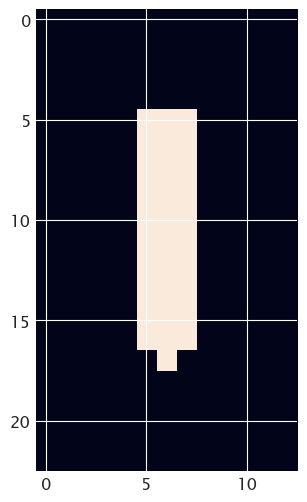

In [93]:
# Compare the mask to the actual image.
mask = fake_mat['CellA'][0]['mask']
plt.imshow(mask)

In [94]:
SS_totint / SS_area

600.0

In [95]:
tot_int / area

600.0